In [1]:
from nufeb_tools import utils,plot
from scipy.integrate import odeint
import numpy as np
import pandas as pd
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

In [2]:
x = utils.get_data(test=True)
#x.single_cell_growth()


<AxesSubplot:xlabel='Distance', ylabel='Count'>

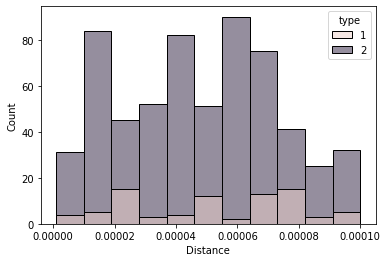

In [18]:
neigh = x.get_neighbor_distance(95,10000)
sns.histplot(x='Distance',hue='type',data=neigh)

In [4]:
fitness = list()
for cell,type_ in zip(x.h5['id']['10000'].__iter__(),x.h5['type']['10000'].__iter__()):
    neigh = x.get_neighbor_distance(cell,10000)
    med = neigh.groupby(['type'])['Distance'].min()
    fitness.append([cell,type_,x.get_fitness(10000,cell),med[1],med[2]])
df = pd.DataFrame(fitness,columns=['ID','Type','Fitness','Distance_1','Distance_2'])

<AxesSubplot:xlabel='ID', ylabel='Fitness'>

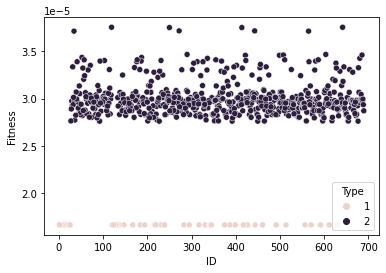

In [5]:
sns.scatterplot(x='ID',y='Fitness',hue='Type',data=df)

<AxesSubplot:xlabel='Distance_1', ylabel='Fitness'>

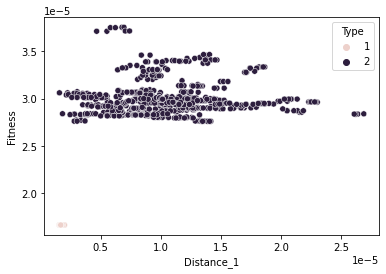

In [6]:
sns.scatterplot(x='Distance_1',y='Fitness',hue='Type',data=df)

<AxesSubplot:xlabel='Distance_1', ylabel='ID'>

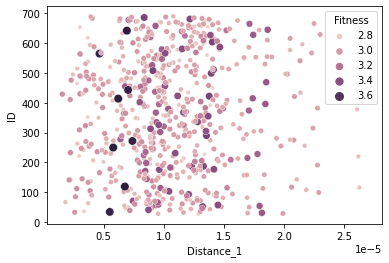

In [7]:
sns.scatterplot(x='Distance_1',y='ID',hue='Fitness',size='Fitness',data=df[df.Type==2])

<AxesSubplot:xlabel='Distance_1', ylabel='Fitness'>

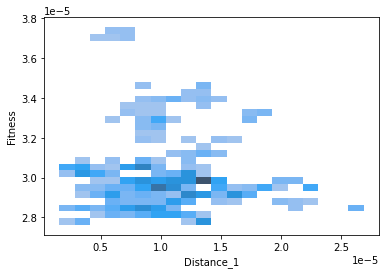

In [8]:
sns.histplot(x='Distance_1',y='Fitness',data=df[df.Type==2])

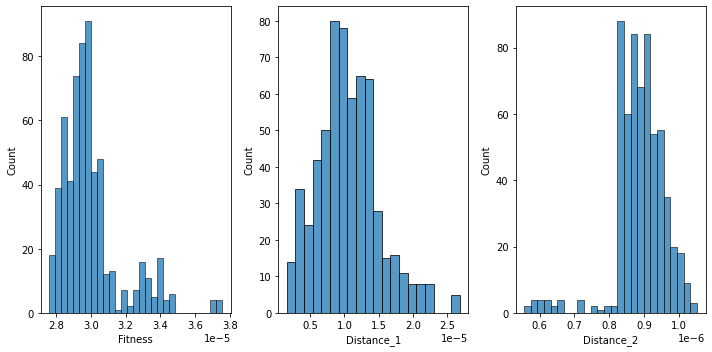

In [9]:
f, axes = plt.subplots(ncols=3,figsize=(10,5))
sns.histplot(x='Fitness',data=df[df.Type==2],ax=axes[0])
sns.histplot(x='Distance_1',data=df[df.Type==2],ax=axes[1])
sns.histplot(x='Distance_2',data=df[df.Type==2],ax=axes[2])
f.tight_layout()

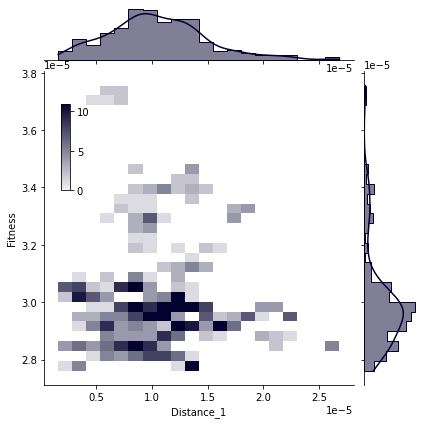

In [10]:
g = sns.JointGrid(data=df[df.Type==2], x="Distance_1", y="Fitness")
#g.ax_joint.set(yscale="log")
cax = g.fig.add_axes([.15, .55, .02, .2])
g.plot_joint(
    sns.histplot, 
    cmap="light:#03012d", cbar=True, cbar_ax=cax,pmax=.8)
g.plot_marginals(sns.histplot, element="step", color="#03012d",kde=True)

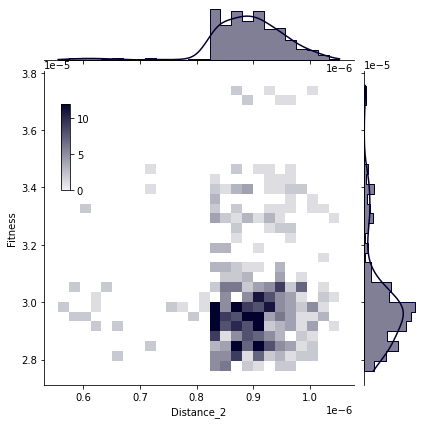

In [11]:
g = sns.JointGrid(data=df[df.Type==2], x="Distance_2", y="Fitness")
#g.ax_joint.set(yscale="log")
cax = g.fig.add_axes([.15, .55, .02, .2])
g.plot_joint(
    sns.histplot, 
    cmap="light:#03012d", cbar=True, cbar_ax=cax,pmax=.8)
g.plot_marginals(sns.histplot, element="step", color="#03012d",kde=True)

<AxesSubplot:xlabel='Distance_1', ylabel='Distance_2'>

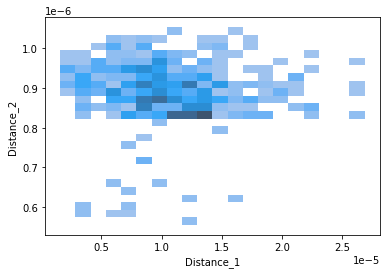

In [12]:
sns.histplot(x='Distance_1',y='Distance_2',data=df[df.Type==2])